In [7]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

* *DESCR:* Descreve o conjunto de dados.
* *data:* contem um array com um linha por instância e uma coluna por caracteristica.
* *target:* contem um array com os rótulos.

In [9]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

Cada instância possui 784 caracteristicas, pois cada imagem tem 28 x 28 pixels. Cada caracteristica representa a intendidade de um pixel de 0 (branco) a 255 (preto)

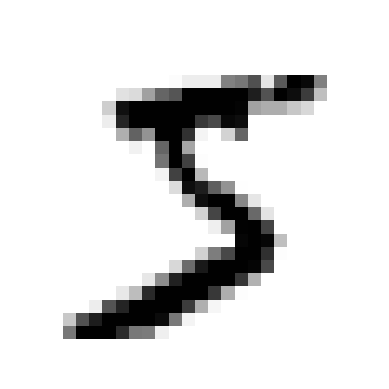

In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_array = X.iloc[0].to_numpy()
some_digit_image = some_digit_array.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [31]:
y[0]

'5'

In [35]:
import numpy as np
y = y.astype(np.uint8)

In [37]:
# Separando as dados em treino e teste
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Por hora, usarei um classificar binário. O alvo será identificar o número 5.

In [38]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [40]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [41]:
sgd_clf.predict([some_digit])

/workspaces/data-analysis-with-python/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [42]:
from  sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [43]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool )
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Acurácia de 90% foi alcançada simplesmente porque cerca de 10% das imagens são "5", assim sendo, caso sempre estime que uma imagem não é um 5, terá razão em cerca de 90% das vezes.

**Acurácia** é a medida de avaliação de respode a pergunta: *"Do total de de previsões, quantas o modelo classificou corretamente?"*

**Fórmula**

$$
\frac{\text{Previsões Corretas}}{\text{Total de Previsões}}
$$

In [44]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [46]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Cada **linha** em uma matrix de confussão representa uma **clsse real**, ao passo que cada **coluna** presenta uma **classe prevista**

|  | 1 | 0 |
|--|---|---|
| 1 | TP | FN |
| 0 | FP | TN |

In [48]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/workspaces/data-analysis-with-python/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

$$
\text{Precisão} = \frac{\text{TP}}{\text{TP + FN}}
$$

**Taxa de revocação** é o mesmo que **recall**. Ele mede a capacidade do modelo de encontrar todos os casos positivos em um conjutno de dados.

Ele responde a pergunta: *"De todos os casos realmente são positivos, qual a porcentagem o modelo conseguiu identificar corretamente?"*

O **F-Score** é uma medida que combina a precisão  e revocação

In [51]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

In [50]:
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [52]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [54]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447], shape=(60000,))

In [55]:
from sklearn.metrics import precision_recall_curve

precisionn, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

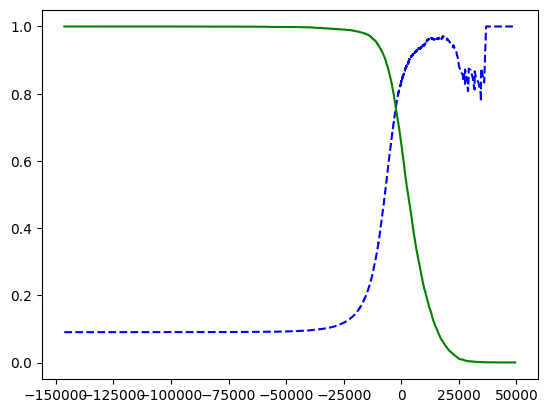

In [56]:
def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    plt.plot(thresholds, precision[:-1], 'b--', label='precision')
    plt.plot(thresholds, recall[:-1], 'g-', label='recall')

plot_precision_recall_vs_threshold(precisionn, recall, thresholds)

**Curva ROC**

A *curva de caracteristica de operação* é uma ferramente de uso comum em classificadores binários. Ela representa a taxa de **verdadeiros positivos** (outro nome para revocação ou recall) em relação a taxa de **positos falso (FPR)**. FPR é a proporsão de instâncias negativas classificadas incorretamente como positivas. A taxa de verdadeiros negativos (TNR) é a proporsão de instâncias  negativas que são classificadas corretamente como negativas. o **TNR** tambem é chamado de especificidade. A curva ROC representa a sensibilidade(revocação) versus a especificidade.


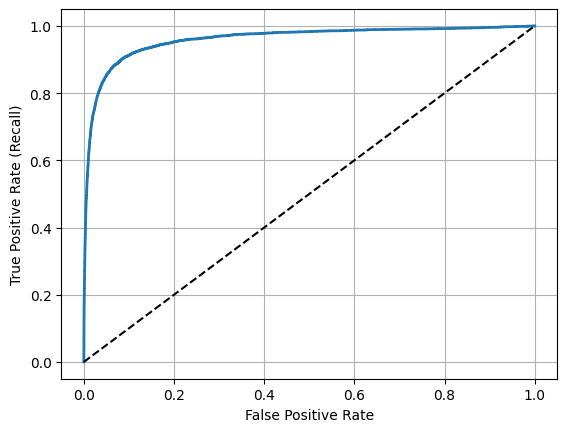

In [60]:
from sklearn.metrics import roc_curve

frp, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(frp, tpr, label=None):
    plt.plot(frp, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.grid(True)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    [...]

plot_roc_curve(frp, tpr)
plt.show()

In [61]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616